In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [11]:
def import_data(num_shards):
    dfs = []
    for i in range(num_shards):
        df = pd.read_csv('results/S' + str(i+1) + '_results.csv')
        dfs.append(df)
    return dfs

In [12]:
dfs = import_data(2)

In [13]:
len(dfs)

2

In [26]:
# The goal is to visualize the the impact of the number of shards on the query time
# We will use the plotly library to create a line chart

# First, we need to create a dataframe with the query time for each shard
# We will use the column 'avg_runtime_no_outliers' of each dataframe

# We will also create a column 'shard' to identify the shard
# We will use the column 'query' to identify the query

# The dataframe will look like this:
# Query, avg_runtime_no_outliers1, avg_runtime_no_outliers2, ...

# We will use the melt function to transform the dataframe
# The dataframe will look like this:
# Query, shard, avg_runtime_no_outliers
 
df = pd.DataFrame()
cols_to_plot = []
for i in range(len(dfs)):
    df['query'] = dfs[i]['query']
    df['query_number'] = dfs[i]['query_number']
    df['avg_runtime_no_outliers' + str(i+1)] = dfs[i]['avg_runtime_no_outliers']
    cols_to_plot.append('avg_runtime_no_outliers' + str(i+1))
df


,query,query_number,avg_runtime_no_outliers1,avg_runtime_no_outliers2
0,[{'$group': {'_id': {'$toLower': '$institution...,1,3646.500,2929.250
1,[{'$match': {'institution.city_name': re.compi...,2,1199.125,1010.250
2,[{'$match': {'investigators.email_id': {'$ne':...,3,2866.625,1427.000
3,[{'$match': {'institution.state_name': 'Califo...,4,1342.000,1125.250
4,"[{'$group': {'_id': '$institution', 'count': {...",5,5607.500,4475.625
5,"[{'$unwind': {'path': '$programs', 'includeArr...",6,3196.375,2574.375
6,[{'$match': {'investigators.email_id': re.comp...,7,2951.125,1504.625
7,[{'$match': {'investigators.email_id': 'jeremy...,8,3.000,3.625


In [27]:
# Plot the results
fig = px.line(df, x="query_number", y=cols_to_plot, title='Query time')
fig.show()

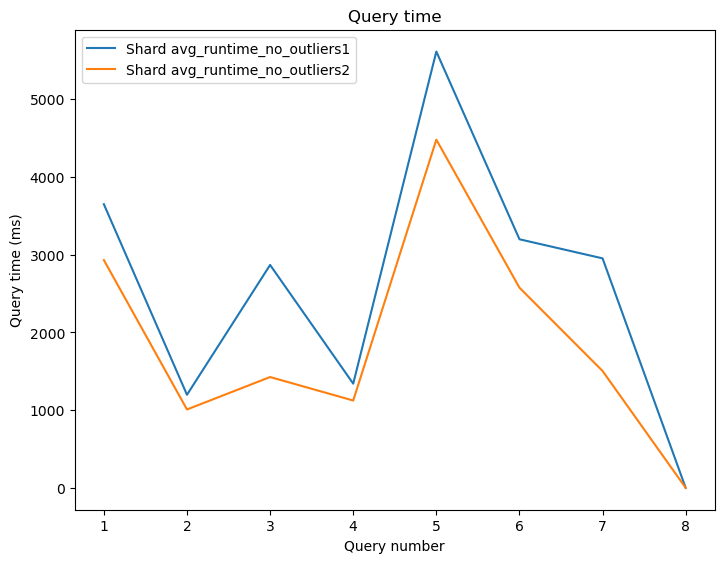

In [29]:
# Plot the same results using matplotlib
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in cols_to_plot:
    ax.plot(df['query_number'], df[i], label=f"Shard {i}")
ax.set_xlabel('Query number')
ax.set_ylabel('Query time (ms)')
ax.set_title('Query time')
ax.legend()
plt.show()

In [30]:
# Plot the results as a side by side bar chart
# We will use the plotly library to create a bar chart
fig = px.bar(df, x="query_number", y=cols_to_plot, barmode='group', title='Query time')
fig.show()